In [1]:
# Regular imports
import pandas as pd 
import numpy as np
import time
import os
import shutil
from datetime import datetime
from openap.phase import FlightPhase
from IPython.display import display, HTML

# Spark imports
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType, lit, col, when, lag, lead, min, max, sum as Fsum, explode, array, monotonically_increasing_id, round
from pyspark.sql.types import DoubleType, StructType, StructField, IntegerType, StringType
from pyspark.sql.window import Window

# Hotfix
#!cp /runtime-addons/cmladdon-2.0.40-b150/log4j.properties /etc/spark/conf/

# Spark Session Initialization
#shutil.copy("/runtime-addons/cmladdon-2.0.40-b150/log4j.properties", "/etc/spark/conf/") # Setting logging properties
spark = SparkSession.builder \
    .appName("OPDI flight events and measurements ETL") \
    .config("spark.log.level", "ERROR")\
    .config("spark.ui.showConsoleProgress", "false")\
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-opdi") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.driver.cores", "1") \
    .config("spark.driver.memory", "10G") \
    .config("spark.executor.memory", "5G") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "10") \
    .config("spark.network.timeout", "800s")\
    .config("spark.executor.heartbeatInterval", "400s") \
    .config('spark.ui.showConsoleProgress', False) \
    .enableHiveSupport() \
    .getOrCreate()

# Get environment variables
engine_id = os.getenv('CDSW_ENGINE_ID')
domain = os.getenv('CDSW_DOMAIN')

# Format the URL
url = f"https://spark-{engine_id}.{domain}"

# Display the clickable URL
display(HTML(f'<a href="{url}">{url}</a>'))

Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


In [2]:
import pandas as pd

tmp = pd.read_parquet('../../data/retrievals/*-to-EIDW/tracks_adep_*_ades_EIDW_2024-03-16.parquet')

In [4]:
# Load your data
# Assuming df is your Spark DataFrame with columns: track_id, ts, alt, spd, roc
start_timestamp = 1672531200  # Example start timestamp
end_timestamp = 1673100000    # Example end timestamp

df = spark.sql(f"""
SELECT *
FROM project_opdi.osn_tracks_clustered
WHERE event_time BETWEEN {start_timestamp} AND {end_timestamp}
""").cache()

def smooth_baro_alt(df):
    # Define the acceptable rate of climb/descent threshold (25.4 meters per second, i.e. 5000ft/min)
    rate_threshold = 25.4

    # Calculate the rate of climb/descent in meters per second for each track_id
    window_spec = Window.partitionBy("track_id").orderBy("event_time")
    df = df.withColumn("prev_baro_altitude", lag("baro_altitude").over(window_spec))
    df = df.withColumn("prev_event_time", lag("event_time").over(window_spec))

    df = df.withColumn("time_diff", (col("event_time") - col("prev_event_time")))
    df = df.withColumn("altitude_diff", (col("baro_altitude") - col("prev_baro_altitude")))
    df = df.withColumn("rate_of_climb", col("altitude_diff") / col("time_diff"))

    # Create a window for calculating the rolling average
    # Define a time window for the rolling average (e.g., 300 seconds or 5 min)
    time_window = 300

    # Create a window specification for calculating the rolling average based on time
    window_spec_avg = Window.partitionBy("track_id").orderBy("event_time").rangeBetween(-time_window, time_window)

    # Calculate the rolling average (smoothing)
    df = df.withColumn("smoothed_baro_altitude", avg("baro_altitude").over(window_spec_avg))

    # Replace unrealistic climb/descent points with the smoothed values
    df = df.withColumn("baro_altitude",
                       when((abs(col("rate_of_climb")) > rate_threshold),
                            col("smoothed_baro_altitude")).otherwise(col("baro_altitude")))

    # Drop the temporary columns
    df = df.drop("smoothed_baro_altitude", "prev_baro_altitude", "prev_event_time", "time_diff", "altitude_diff", "rate_of_climb")
    return df

df = smooth_baro_alt(df)

df.limit(1).toPandas()

Hive Session ID = a4b2a444-ae1b-4576-914d-631277dc1a79


NameError: name 'avg' is not defined

In [ ]:


# Define fuzzy membership functions using native Spark functions
def zmf(col, a, b):
    """Zero-order membership function (ZMF)."""
    return F.when(col <= a, 1).when(col >= b, 0).otherwise((b - col) / (b - a))

def gaussmf(col, mean, sigma):
    """Gaussian membership function (GaussMF)."""
    return F.exp(-((col - mean) ** 2) / (2 * sigma ** 2))

def smf(col, a, b):
    """S-shaped membership function (SMF)."""
    return F.when(col <= a, 0).when(col >= b, 1).otherwise((col - a) / (b - a))

# Extracting OpenAP phases
df = df.withColumn("alt", col("baro_altitude") * 3.28084)
df = df.withColumn("roc", col("vert_rate") * 196.850394)
df = df.withColumn("spd", col("velocity") * 1.94384)

# Apply membership functions to the DataFrame
df = df.withColumn("alt_gnd", zmf(F.col("alt"), 0, 200))
df = df.withColumn("alt_lo", gaussmf(F.col("alt"), 10000, 10000))
df = df.withColumn("alt_hi", gaussmf(F.col("alt"), 35000, 20000))
df = df.withColumn("roc_zero", gaussmf(F.col("roc"), 0, 100))
df = df.withColumn("roc_plus", smf(F.col("roc"), 10, 1000))
df = df.withColumn("roc_minus", zmf(F.col("roc"), -1000, -10))
df = df.withColumn("spd_hi", gaussmf(F.col("spd"), 600, 100))
df = df.withColumn("spd_md", gaussmf(F.col("spd"), 300, 100))
df = df.withColumn("spd_lo", gaussmf(F.col("spd"), 0, 50))

# Define window specification for time windows
window_spec = Window.partitionBy("track_id").orderBy("event_time").rangeBetween(Window.unboundedPreceding, 0)

# Aggregate and apply fuzzy logic within each window
df = df.withColumn("alt_mean", F.avg("alt").over(window_spec))
df = df.withColumn("spd_mean", F.avg("spd").over(window_spec))
df = df.withColumn("roc_mean", F.avg("roc").over(window_spec))

# Apply fuzzy logic rules
df = df.withColumn("rule_ground", F.least(F.col("alt_gnd"), F.col("roc_zero"), F.col("spd_lo")))
df = df.withColumn("rule_climb", F.least(F.col("alt_lo"), F.col("roc_plus"), F.col("spd_md")))
df = df.withColumn("rule_descent", F.least(F.col("alt_lo"), F.col("roc_minus"), F.col("spd_md")))
df = df.withColumn("rule_cruise", F.least(F.col("alt_hi"), F.col("roc_zero"), F.col("spd_hi")))
df = df.withColumn("rule_level", F.least(F.col("alt_lo"), F.col("roc_zero"), F.col("spd_md")))

# Aggregate and determine phase label
df = df.withColumn("aggregated", F.greatest(F.col("rule_ground"), F.col("rule_climb"), F.col("rule_descent"), F.col("rule_cruise"), F.col("rule_level")))
df = df.withColumn("flight_phase", F.when(F.col("aggregated") == F.col("rule_ground"), "GND")
                                 .when(F.col("aggregated") == F.col("rule_climb"), "CL")
                                 .when(F.col("aggregated") == F.col("rule_descent"), "DE")
                                 .when(F.col("aggregated") == F.col("rule_cruise"), "CR")
                                 .when(F.col("aggregated") == F.col("rule_level"), "LVL"))

# Show result
df_res1 = df.limit(100000).toPandas()

In [ ]:
df_res1.to_parquet('df_res1_new_method.parquet')

In [ ]:
import plotly.express as px

px.line(df_res1.sort_values(['track_id','event_time']), x='event_time', y = 'baro_altitude', color = 'phase_label', symbol = 'track_id')

In [4]:
# Load your data
# Assuming df is your Spark DataFrame with columns: track_id, ts, alt, spd, roc
df = spark.sql("""
SELECT *
FROM project_opdi.osn_tracks_clustered
WHERE track_id IN (
    '04f63db01647136d269f355c6ce5810493023cf47247f8e174949844755250bc_0_2024_3',
    'f7a7d3747c6e857659bb517e066c683c179b55b23f69f75cd49fef55f91d3762_2_2024_3',
    '6634265c16ce2cca02e3a5da5783591c0622df6210bd6a06f2c7ed701866c479_0_2024_3',
    '3b036233f897f810a8a0a782dee05da985ddf83f5548702eadc37d23e0eff0ce_3_2024_3',
    '64ae7b01f05dc21123b5f49c941305bf22005482f8d989300226aec201a0a706_2_2024_3',
    '7a3afb66e199f0acd0398deead70fc7ef8ed507145d6ccb98d8a5db19dbaa135_0_2024_3',
    'b2e1a1618c843ee99dc7165372b4cb11466b5ae4395bb35916fa6eb3b88f7f6d_0_2024_3'
);""").cache()

df = df.withColumn("altitude_ft", col("baro_altitude") * 3.28084)
df = df.withColumn("roc_ft_min", col("vert_rate") * 196.850394)
df = df.withColumn("speed_kt", col("velocity") * 1.94384)

df = df.select("track_id", "lat", "lon", "event_time", "altitude_ft", "roc_ft_min", "speed_kt")

## Define schema for UDF
schema = StructType([
    StructField("track_id", StringType()),
    #StructField("icao24", StringType()),
    #StructField("callsign", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("event_time", IntegerType()),
    #StructField("baro_altitude", DoubleType()),
    #StructField("velocity", DoubleType()),
    #StructField("vert_rate", DoubleType()),
    #StructField("cumulative_distance_nm", DoubleType()),
    #StructField("cumulative_time_s", IntegerType()),
    StructField("altitude_ft", DoubleType()),
    StructField("roc_ft_min", DoubleType()),
    StructField("speed_kt", DoubleType()),
    StructField("flight_phase", StringType())
])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def get_flight_phases(pdf):
    try:
        fp = FlightPhase()
        fp.set_trajectory(pdf['event_time'], pdf['altitude_ft'], pdf['speed_kt'], pdf['roc_ft_min'])
        pdf['flight_phase'] = fp.phaselabel()
    except: 
        pdf['flight_phase'] = None

    return pdf

## Apply UDF to get flight phases
df_with_phases = df.groupby("track_id").apply(get_flight_phases)


df_res2 = df_with_phases.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


In [5]:
df_res2.to_parquet('df_res2.parquet')

## Analysis

In [15]:
df_res2 = pd.read_parquet('df_res2.parquet')

In [16]:
df_res1 = pd.read_parquet('df_res1_new_method.parquet')

In [22]:
df_res1 = df_res1[[x for x in df_res2.columns if x not in ['altitude_ft', 'roc_ft_min', 'speed_kt', 'flight_phase'] ] + ['phase_label']]

In [23]:
df_res2 = df_res2.rename({'flight_phase':'flight_label_original'},axis=1)

In [27]:
df_res1

,track_id,lat,lon,event_time,phase_label
0,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464813,-0.479761,1710578675,CL
1,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464802,-0.482712,1710578680,CL
2,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464756,-0.490875,1710578685,CL
3,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464722,-0.496315,1710578690,CL
4,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464722,-0.501808,1710578695,CL
...,...,...,...,...,...
9212,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606355,DE
9213,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606360,DE
9214,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606365,DE
9215,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606370,DE


In [35]:
df = df_res1.merge(df_res2, on = ['track_id', 'lat', 'lon', 'event_time'], how = 'left')

In [37]:
df['check'] = df['phase_label'] == df['flight_label_original']

In [38]:
df['check'].value_counts()

True     8056
False    1161
Name: check, dtype: int64

In [55]:
df

,track_id,lat,lon,event_time,phase_label,altitude_ft,roc_ft_min,speed_kt,flight_label_original,check
0,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464813,-0.479761,1710578675,CL,425.000014,2560.000004,151.002832,CL,True
1,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464802,-0.482712,1710578680,CL,650.000021,2496.000004,151.012765,CL,True
2,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464756,-0.490875,1710578685,CL,875.000028,2432.000004,151.002832,CL,True
3,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464722,-0.496315,1710578690,CL,1050.000034,1984.000003,151.999517,CL,True
4,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.464722,-0.501808,1710578695,CL,1200.000038,1536.000002,157.999498,CL,True
...,...,...,...,...,...,...,...,...,...,...
9212,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606355,DE,NaN,-704.000001,149.752655,LVL,False
9213,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606360,DE,NaN,-704.000001,149.752655,LVL,False
9214,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606365,DE,NaN,-704.000001,149.752655,LVL,False
9215,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606370,DE,NaN,-704.000001,149.752655,LVL,False


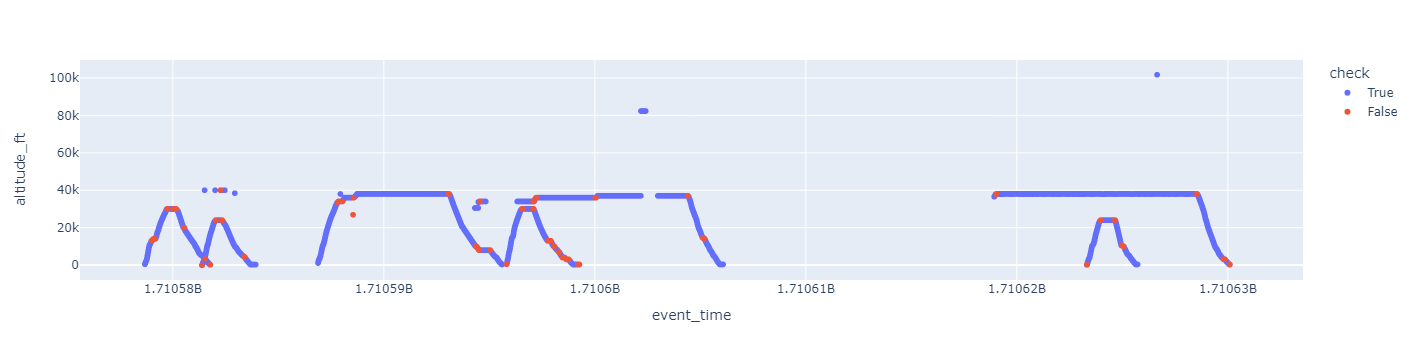

In [58]:
import plotly.express as px

px.scatter(df, x='event_time', y='altitude_ft', color = 'check', hover_data = ['phase_label', 'flight_label_original'])

In [53]:
px.scatter?

Signature:
px.scatter(
    data_frame=None,
    x=None,
    y=None,
    color=None,
    symbol=None,
    size=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    text=None,
    facet_row=None,
    facet_col=None,
    facet_col_wrap=0,
    facet_row_spacing=None,
    facet_col_spacing=None,
    error_x=None,
    error_x_minus=None,
    error_y=None,
    error_y_minus=None,
    animation_frame=None,
    animation_group=None,
    category_orders=None,
    labels=None,
    orientation=None,
    color_discrete_sequence=None,
    color_discrete_map=None,
    color_continuous_scale=None,
    range_color=None,
    color_continuous_midpoint=None,
    symbol_sequence=None,
    symbol_map=None,
    opacity=None,
    size_max=None,
    marginal_x=None,
    marginal_y=None,
    trendline=None,
    trendline_options=None,
    trendline_color_override=None,
    trendline_scope='trace',
    log_x=False,
    log_y=False,
    range_x=None,
    range_y=None,
    render_mode='auto',


In [39]:
df[df['check'] == False]

,track_id,lat,lon,event_time,phase_label,altitude_ft,roc_ft_min,speed_kt,flight_label_original,check
64,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.435754,-1.070328,1710578995,LVL,13000.000416,128.000000,343.081991,CL,False
65,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.440689,-1.079407,1710579000,LVL,13025.000417,-64.000000,342.985791,CL,False
66,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.445953,-1.088983,1710579005,LVL,13000.000416,-64.000000,342.327702,CL,False
67,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.451172,-1.098633,1710579010,LVL,13000.000416,0.000000,343.081991,CL,False
82,04f63db01647136d269f355c6ce5810493023cf47247f8...,51.529037,-1.245018,1710579085,LVL,13975.000447,128.000000,348.396655,CL,False
...,...,...,...,...,...,...,...,...,...,...
9212,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606355,DE,NaN,-704.000001,149.752655,LVL,False
9213,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606360,DE,NaN,-704.000001,149.752655,LVL,False
9214,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606365,DE,NaN,-704.000001,149.752655,LVL,False
9215,f7a7d3747c6e857659bb517e066c683c179b55b23f69f7...,53.431949,-6.244536,1710606370,DE,NaN,-704.000001,149.752655,LVL,False


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import exp, when, col

# Initialize Spark Session
spark = SparkSession.builder.appName("FuzzyMembershipFunctions").getOrCreate()

# Define Gaussian Membership Function
def gaussmf(df, input_col, mean, sigma):
     """
    Gaussian fuzzy membership function.

    Parameters
    ----------
    df: PySpark Dataframe
        Dataframe containing column which is the independent variable.
    input_col : string
        Name of te column which is the independent variable.
    mean : float
        Gaussian parameter for center (mean) value.
    sigma : float
        Gaussian parameter for standard deviation.

    Returns
    -------
    df : PySpark Dataframe with gaussmf column. 
        Gaussian membership function for x.
    """
    return df.withColumn("gaussmf", exp(-((col(input_col) - mean) ** 2) / (2 * sigma ** 2)))

# Define Z-shaped Membership Function
def zmf(df, input_col, a, b):
    """
    Z-function fuzzy membership generator.

    Parameters
    ----------
    df: PySpark Dataframe
        Dataframe containing column which is the independent variable.
    input_col : string
        Name of te column which is the independent variable.
    a : float
        'ceiling', where the function begins falling from 1.
    b : float
        'foot', where the function reattains zero.

    Returns
    -------
    df : PySpark Dataframe with zmf column. 
        Z-function.

    Notes
    -----
    Named such because of its Z-like shape.
    """
    assert a <= b, "a <= b is required."
    return df.withColumn("zmf",
                         when(col(input_col) < a, 1)
                         .when(col(input_col) < (a + b) / 2, 1 - 2 * ((col(input_col) - a) / (b - a)) ** 2)
                         .when(col(input_col) <= b, 2 * ((col(input_col) - b) / (b - a)) ** 2)
                         .otherwise(0))

# Define S-shaped Membership Function
def smf(df, input_col, a, b):
    """
    S-function fuzzy membership generator.

    Parameters
    ----------
    df: PySpark Dataframe
        Dataframe containing column which is the independent variable.
    input_col : string
        Name of te column which is the independent variable.
    a : float
        'foot', where the function begins to climb from zero.
    b : float
        'ceiling', where the function levels off at 1.

    Returns
    -------
    df : PySpark Dataframe with smf column. 
        S-function.

    Notes
    -----
    Named such because of its S-like shape.
    """
    assert a <= b, "a <= b is required."
    return df.withColumn("smf",
                         when(col(input_col) <= a, 0)
                         .when(col(input_col) <= (a + b) / 2, 2 * ((col(input_col) - a) / (b - a)) ** 2)
                         .when(col(input_col) <= b, 1 - 2 * ((col(input_col) - b) / (b - a)) ** 2)
                         .otherwise(1))

def interp_membership(df, x_col, xmf_col, xx, zero_outside_x=True):
    """
    Find the degree of membership `u(xx)` for a given value of `x = xx`
    using Pandas-on-Spark DataFrame for interpolation.

    Parameters:
    df (ps.DataFrame): DataFrame containing the columns for x and xmf.
    x_col (str): Column name for the x values.
    xmf_col (str): Column name for the membership function values.
    xx (float): The point at which to interpolate the membership.
    zero_outside_x (bool): Flag to determine how to handle extrapolation.

    Returns:
    ps.DataFrame: DataFrame with interpolated membership values at xx.
    """

    # Ensure the DataFrame is ordered by x_col for correct interpolation
    df = df.sort_values(x_col)

    # Use interpolation
    interpolated_df = df[[x_col, xmf_col]].interpolate()

    # Handling zero_outside_x
    if zero_outside_x:
        # If xx is outside the range of x_col, set extrapolated values to zero
        min_x, max_x = df[x_col].min(), df[x_col].max()
        if xx < min_x or xx > max_x:
            return 0
        else:
            # Find the closest index in the interpolated DataFrame
            closest_index = interpolated_df[x_col].sub(xx).abs().idxmin()
            return interpolated_df.iloc[closest_index][xmf_col]
    else:
        # Find the closest index in the interpolated DataFrame
        closest_index = interpolated_df[x_col].sub(xx).abs().idxmin()
        return interpolated_df.iloc[closest_index][xmf_col]

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max as max_, mean, min as min_
from pyspark.sql.window import Window


def defuzz(df, x_col, mfx_col, mode):
    """
    Defuzzification of a membership function in a Spark DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the columns for x and membership function.
    x_col (str): Column name for the independent variable.
    mfx_col (str): Column name for the membership function values.
    mode (str): Method of defuzzification ('mom', 'som', 'lom').

    Returns:
    float: Defuzzified result.
    """
    mode = mode.lower()
    if mode not in ['mom', 'som', 'lom']:
        raise ValueError(f"The mode: {mode} was incorrect.")
    
    # Calculate the maximum membership value
    max_mfx = df.agg(max_(col(mfx_col)).alias("max_mfx")).collect()[0]['max_mfx']

    # Filter DataFrame to only include rows where membership function equals the maximum value
    max_df = df.filter(col(mfx_col) == max_mfx)

    if mode == 'mom':
        # Mean of Maximum
        return max_df.agg(mean(col(x_col)).alias("mom")).collect()[0]['mom']
    elif mode == 'som':
        # Min of Maximum
        return max_df.agg(min_(col(x_col)).alias("som")).collect()[0]['som']
    elif mode == 'lom':
        # Max of Maximum
        return max_df.agg(max_(col(x_col)).alias("lom")).collect()[0]['lom']

# Example usage:
# Assuming df is your DataFrame with 'x' as independent variable column and 'mfx' as membership function values column:
# defuzzified_value = defuzz(df, 'x', 'mfx', 'mom')


In [ ]:
%%time
from openap.phase import FlightPhase
fp = FlightPhase()

CPU times: user 4.21 ms, sys: 55 µs, total: 4.26 ms
Wall time: 3.7 ms


In [ ]:
class FlightPhase(object):
    """Fuzzy logic flight phase identification."""

    def __init__(self):
        """Initialize of the FlightPhase object."""
        super(FlightPhase, self).__init__()

        # logic states
        self.alt_range = np.arange(0, 40000, 1)
        self.roc_range = np.arange(-4000, 4000, 0.1)
        self.spd_range = np.arange(0, 600, 1)
        self.states = np.arange(0, 6, 0.01)

        self.alt_gnd = fuzzy.zmf(self.alt_range, 0, 200)
        self.alt_lo = fuzzy.gaussmf(self.alt_range, 10000, 10000)
        self.alt_hi = fuzzy.gaussmf(self.alt_range, 35000, 20000)

        self.roc_zero = fuzzy.gaussmf(self.roc_range, 0, 100)
        self.roc_plus = fuzzy.smf(self.roc_range, 10, 1000)
        self.roc_minus = fuzzy.zmf(self.roc_range, -1000, -10)

        self.spd_hi = fuzzy.gaussmf(self.spd_range, 600, 100)
        self.spd_md = fuzzy.gaussmf(self.spd_range, 300, 100)
        self.spd_lo = fuzzy.gaussmf(self.spd_range, 0, 50)

        self.state_ground = fuzzy.gaussmf(self.states, 1, 0.1)
        self.state_climb = fuzzy.gaussmf(self.states, 2, 0.1)
        self.state_descent = fuzzy.gaussmf(self.states, 3, 0.1)
        self.state_cruise = fuzzy.gaussmf(self.states, 4, 0.1)
        self.state_level = fuzzy.gaussmf(self.states, 5, 0.1)

        self.state_lable_map = {1: "GND", 2: "CL", 3: "DE", 4: "CR", 5: "LVL"}

        self.ts = None
        self.alt = None
        self.spd = None
        self.roc = None

In [ ]:
FlightPhase()

NameError: name 'fuzzy' is not defined

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import exp, col, when

class FlightPhase:
    """Fuzzy logic flight phase identification using PySpark."""

    def __init__(self, spark_session):
        """Initialize the FlightPhase object with necessary configurations and Spark session."""
        self.spark = spark_session

        # Placeholder attributes for DataFrame that will store trajectory data
        self.trajectory_df = None
        
        # Initialize the membership functions directly within the class
        # Assuming the methods gaussmf, zmf, and smf are defined externally and will be set up here
    
        self.alt_range = self.create_spark_dataframe(np.arange(0, 40000, 1), "altitude")
        self.roc_range = self.create_spark_dataframe(np.arange(-4000, 4000, 0.1), "roc")
        self.spd_range = self.create_spark_dataframe(np.arange(0, 600, 1), "speed")
        self.states = self.create_spark_dataframe(np.arange(0, 6, 0.01), "state")

    def create_spark_dataframe(self, np_array, column_name):
        """
        Convert a NumPy array to a Spark DataFrame with a specified column name.

        Args:
            np_array (np.array): The NumPy array to convert.
            column_name (str): The name of the column for the DataFrame.

        Returns:
            pyspark.sql.DataFrame: The resulting Spark DataFrame.
        """
        df = self.spark.createDataFrame([(float(x),) for x in np_array], [column_name])
        return df
    
    def gaussmf(self, df, input_col, mean, sigma):
        """Gaussian membership function applied to DataFrame column."""
        return df.withColumn("gaussmf", exp(-((col(input_col) - mean) ** 2) / (2 * sigma ** 2)))

    def zmf(self, df, input_col, a, b):
        """Z-shaped membership function applied to DataFrame column."""
        return df.withColumn("zmf", 
                             when(col(input_col) < a, 1)
                             .when(col(input_col) < (a + b) / 2, 1 - 2 * ((col(input_col) - a) / (b - a)) ** 2)
                             .when(col(input_col) <= b, 2 * ((col(input_col) - b) / (b - a)) ** 2)
                             .otherwise(0))

    def smf(self, df, input_col, a, b):
        """S-shaped membership function applied to DataFrame column."""
        return df.withColumn("smf",
                             when(col(input_col) <= a, 0)
                             .when(col(input_col) <= (a + b) / 2, 2 * ((col(input_col) - a) / (b - a)) ** 2)
                             .when(col(input_col) <= b, 1 - 2 * ((col(input_col) - b) / (b - a)) ** 2)
                             .otherwise(1))

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, array, max as spark_max
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

class FlightPhase:
    """Fuzzy logic flight phase identification using PySpark."""

    def __init__(self, spark_session):
        """Initialize the FlightPhase object with a Spark session."""
        self.spark = spark_session

        # Assuming the membership functions and their implementation are provided as udf's
        # For example:
        # self.gaussmf_udf = udf(gaussmf, DoubleType())
        # self.zmf_udf = udf(zmf, DoubleType())
        # self.smf_udf = udf(smf, DoubleType())

    def set_trajectory(self, trajectory_df):
        """Set the DataFrame containing trajectory data.
        Expected DataFrame schema: ['timestamp', 'altitude', 'speed', 'rate_of_climb']"""
        self.trajectory_df = trajectory_df

    def calculate_membership_values(self):
        """Calculate fuzzy membership values for each trajectory point."""
        # Example of applying a Gaussian membership function to the altitude
        self.trajectory_df = self.trajectory_df.withColumn(
            "alt_lo_membership",
            self.gaussmf_udf(col("altitude"), lit(10000), lit(10000))
        )
        # Add more membership calculations as necessary

    def determine_flight_phases(self):
        """Determine the flight phase for each point using fuzzy logic rules."""
        # Implement fuzzy logic rules to determine flight phases
        # For example:
        self.trajectory_df = self.trajectory_df.withColumn(
            "phase_ground",
            when(col("alt_lo_membership") > 0.5, lit("Ground")).otherwise(lit("Air"))
        )
        # Extend with more complex logic as required

    def execute(self):
        """Execute the phase detection logic."""
        self.calculate_membership_values()
        self.determine_flight_phases()
        return self.trajectory_df

# Usage:
# Initialize Spark Session
spark = SparkSession.builder.appName("FlightPhaseDetection").getOrCreate()

# Example data setup
data = [
    (1, 100, 300, 20),
    (2, 5000, 400, -50),
    # Add more data points as necessary
]
schema = ["timestamp", "altitude", "speed", "rate_of_climb"]
trajectory_df = spark.createDataFrame(data, schema=schema)

# Initialize the FlightPhase detector
flight_phase_detector = FlightPhase(spark)
flight_phase_detector.set_trajectory(trajectory_df)
result_df = flight_phase_detector.execute()

# Show the result
result_df.show()


In [ ]:
"""Using fuzzy logic to indentify flight phase in trajectory data."""


class FlightPhase(object):
    """Fuzzy logic flight phase identification."""

    def __init__(self):
        """Initialize of the FlightPhase object."""
        super(FlightPhase, self).__init__()

        # logic states
        self.alt_range = np.arange(0, 40000, 1)
        self.roc_range = np.arange(-4000, 4000, 0.1)
        self.spd_range = np.arange(0, 600, 1)
        self.states = np.arange(0, 6, 0.01)

        self.alt_gnd = fuzzy.zmf(self.alt_range, 0, 200)
        self.alt_lo = fuzzy.gaussmf(self.alt_range, 10000, 10000)
        self.alt_hi = fuzzy.gaussmf(self.alt_range, 35000, 20000)

        self.roc_zero = fuzzy.gaussmf(self.roc_range, 0, 100)
        self.roc_plus = fuzzy.smf(self.roc_range, 10, 1000)
        self.roc_minus = fuzzy.zmf(self.roc_range, -1000, -10)

        self.spd_hi = fuzzy.gaussmf(self.spd_range, 600, 100)
        self.spd_md = fuzzy.gaussmf(self.spd_range, 300, 100)
        self.spd_lo = fuzzy.gaussmf(self.spd_range, 0, 50)

        self.state_ground = fuzzy.gaussmf(self.states, 1, 0.1)
        self.state_climb = fuzzy.gaussmf(self.states, 2, 0.1)
        self.state_descent = fuzzy.gaussmf(self.states, 3, 0.1)
        self.state_cruise = fuzzy.gaussmf(self.states, 4, 0.1)
        self.state_level = fuzzy.gaussmf(self.states, 5, 0.1)

        self.state_lable_map = {1: "GND", 2: "CL", 3: "DE", 4: "CR", 5: "LVL"}

        self.ts = None
        self.alt = None
        self.spd = None
        self.roc = None

    def set_trajectory(self, ts, alt, spd, roc):
        """Set trajectory data.

        Args:
            ts (list): Time (unit: second).
            alt (list): Altitude (unit: ft).
            spd (list): True airspeed (unit: kt).
            roc (list): Rate of climb (unit: ft/min). Negative for descent.

        """
        self.ts = ts - ts[0]
        self.alt = alt
        self.spd = spd
        self.roc = roc

        if len(set([len(self.ts), len(self.alt), len(self.spd), len(self.roc)])) > 1:
            raise RuntimeError("Input lists must have same length.")

        self.ndata = len(self.ts)

        return

    def phaselabel(self, twindow=60):
        """Fuzzy logic for determining phase label.

        Args:
            twindow (int): Time window in number of seconds. Default to 60.

        Returns:
            list: Labels could be: ground [GND], climb [CL], descent [DE],
                cruise [CR], leveling [LVL].

        """
        if self.ts is None:
            raise RuntimeError(
                "Trajectory data not set, run set_trajectory(ts, alt, spd, roc) first"
            )

        idxs = np.arange(0, self.ndata)

        labels = ["NA"] * self.ndata

        twindows = self.ts // twindow

        for tw in range(0, int(max(twindows))):
            if tw not in twindows:
                continue

            mask = twindows == tw

            idxchk = idxs[mask]
            altchk = self.alt[mask]
            spdchk = self.spd[mask]
            rocchk = self.roc[mask]

            # mean value or extream value as range
            alt = max(min(np.mean(altchk), self.alt_range[-1]), self.alt_range[0])
            spd = max(min(np.mean(spdchk), self.spd_range[-1]), self.spd_range[0])
            roc = max(min(np.mean(rocchk), self.roc_range[-1]), self.roc_range[0])

            # make sure values are within the boundaries
            alt = max(min(alt, self.alt_range[-1]), self.alt_range[0])
            spd = max(min(spd, self.spd_range[-1]), self.spd_range[0])
            roc = max(min(roc, self.roc_range[-1]), self.roc_range[0])

            alt_level_gnd = fuzzy.interp_membership(self.alt_range, self.alt_gnd, alt)
            alt_level_lo = fuzzy.interp_membership(self.alt_range, self.alt_lo, alt)
            alt_level_hi = fuzzy.interp_membership(self.alt_range, self.alt_hi, alt)

            spd_level_hi = fuzzy.interp_membership(self.spd_range, self.spd_hi, spd)
            spd_level_md = fuzzy.interp_membership(self.spd_range, self.spd_md, spd)
            spd_level_lo = fuzzy.interp_membership(self.spd_range, self.spd_lo, spd)

            roc_level_zero = fuzzy.interp_membership(self.roc_range, self.roc_zero, roc)
            roc_level_plus = fuzzy.interp_membership(self.roc_range, self.roc_plus, roc)
            roc_level_minus = fuzzy.interp_membership(
                self.roc_range, self.roc_minus, roc
            )

            # print alt_level_gnd, alt_level_lo, alt_level_hi
            # print roc_level_zero, roc_level_plus, roc_level_minus
            # print spd_level_hi, spd_level_md, spd_level_lo

            rule_ground = min(alt_level_gnd, roc_level_zero, spd_level_lo)
            state_activate_ground = np.fmin(rule_ground, self.state_ground)

            rule_climb = min(alt_level_lo, roc_level_plus, spd_level_md)
            state_activate_climb = np.fmin(rule_climb, self.state_climb)

            rule_descent = min(alt_level_lo, roc_level_minus, spd_level_md)
            state_activate_descent = np.fmin(rule_descent, self.state_descent)

            rule_cruise = min(alt_level_hi, roc_level_zero, spd_level_hi)
            state_activate_cruise = np.fmin(rule_cruise, self.state_cruise)

            rule_level = min(alt_level_lo, roc_level_zero, spd_level_md)
            state_activate_level = np.fmin(rule_level, self.state_level)

            aggregated = np.max(
                np.vstack(
                    [
                        state_activate_ground,
                        state_activate_climb,
                        state_activate_descent,
                        state_activate_cruise,
                        state_activate_level,
                    ]
                ),
                axis=0,
            )

            state_raw = fuzzy.defuzz(self.states, aggregated, "lom")
            state = int(round(state_raw))
            if state > 6:
                state = 6
            if state < 1:
                state = 1

            if len(idxchk) > 0:
                label = self.state_lable_map[state]
                labels[idxchk[0] : (idxchk[-1] + 1)] = [label] * len(idxchk)

        return labels

    def plot_logics(self):
        """Visualize fuzzy logic membership functions."""
        plt.figure(figsize=(10, 8))

        plt.subplot(411)
        plt.plot(self.alt_range, self.alt_gnd, lw=2, label="Ground")
        plt.plot(self.alt_range, self.alt_lo, lw=2, label="Low")
        plt.plot(self.alt_range, self.alt_hi, lw=2, label="High")
        plt.ylim([-0.05, 1.05])
        plt.ylabel("Altitude (ft)")
        plt.yticks([0, 1])
        plt.legend()

        plt.subplot(412)
        plt.plot(self.roc_range, self.roc_zero, lw=2, label="Zero")
        plt.plot(self.roc_range, self.roc_plus, lw=2, label="Positive")
        plt.plot(self.roc_range, self.roc_minus, lw=2, label="Negative")
        plt.ylim([-0.05, 1.05])
        plt.ylabel("RoC (ft/m)")
        plt.yticks([0, 1])
        plt.legend()

        plt.subplot(413)
        plt.plot(self.spd_range, self.spd_hi, lw=2, label="High")
        plt.plot(self.spd_range, self.spd_md, lw=2, label="Midium")
        plt.plot(self.spd_range, self.spd_lo, lw=2, label="Low")
        plt.ylim([-0.05, 1.05])
        plt.ylabel("Speed (kt)")
        plt.yticks([0, 1])
        plt.legend()

        plt.subplot(414)
        plt.plot(self.states, self.state_ground, lw=2, label="ground")
        plt.plot(self.states, self.state_climb, lw=2, label="climb")
        plt.plot(self.states, self.state_descent, lw=2, label="descent")
        plt.plot(self.states, self.state_cruise, lw=2, label="cruise")
        plt.plot(self.states, self.state_level, lw=2, label="level flight")
        plt.ylim([-0.05, 1.05])
        plt.ylabel("Flight Phases")
        plt.yticks([0, 1])
        plt.legend(prop={"size": 7})
        plt.show()

    def _get_to_ic(self):
        # get the data chunk up to certain ft
        istart = 0
        iend = 0
        for i in range(0, self.ndata):
            if self.alt[i] < 1500:  # ft
                iend = i
                continue
            else:
                break

        # keep only the chunk in taking-off states, break at starting point
        spdtmp = self.spd[iend]
        for i in reversed(list(range(0, iend))):
            if self.spd[i] < 30 and self.spd[i] > spdtmp:
                break
            elif self.spd[i] < 5:
                break
            else:
                istart = i
                spdtmp = self.spd[i]

        # ignore too long take-off
        if self.ts[iend] - self.ts[istart] > 300:
            return None

        # ignore insufficient chunk size
        if iend - istart < 10:
            return None

        # ignore no in air data
        if self.alt[iend] < 200:
            return None

        # find the liftoff moment
        ilof = istart
        for i in range(istart + 1, iend):
            if abs(self.alt[i] - self.alt[i - 1]) > 10:
                ilof = i
                break

        # not sufficient data
        if ilof - istart < 5:
            return None

        return (istart, ilof, iend + 1)

    def _get_fa_ld(self):

        # get the approach + landing data chunk (h=0)
        istart = 0
        iend = 0

        for i in reversed(list(range(0, self.ndata))):
            if self.alt[i] < 1500:  # ft
                istart = i
            else:
                break

        # keep only the chunk in landing deceleration states, break at taxing point
        spdtmp = self.spd[istart]
        for i in range(istart, self.ndata):
            if self.spd[i] <= 50 and self.spd[i] >= spdtmp:  # kts
                break
            elif self.spd[i] < 30:
                break
            else:
                iend = i
                spdtmp = self.spd[i]

        # ignore insufficient chunk size
        # if iend - istart < 20:
        #     return None

        # ignore QNH altitude, or no in-air data
        if self.alt[istart] < 100:
            return None

        # # ignore where the end speed too high, ie. not breaked
        # if spd[iend] > 60: # kts
        #     return None

        # find the landing moment
        ild = iend
        for i in reversed(list(range(istart, iend - 1))):
            if abs(self.alt[i] - self.alt[i + 1]) > 10:
                ild = i
                break

        # ignore ground or air data sample less than 4
        if ild - istart < 5 or iend - ild < 5:
            return None

        return (istart, ild, iend + 1)

    def _get_cl(self):
        labels = np.array(self.phaselabel())

        if "CL" not in labels:
            return None

        idx = np.where(np.array(labels) == "CL")[0]

        istart = idx[0]
        iend = idx[-1]

        return istart, iend

    def _get_de(self):

        labels = np.array(self.phaselabel())

        if "DE" not in labels:
            return None

        idx = np.where(np.array(labels) == "DE")[0]

        istart = idx[0]
        iend = idx[-1]

        if "LVL" in labels[istart:iend]:
            isCDA = False
        else:
            isCDA = True

        return istart, iend, isCDA

    def _get_cr(self):
        # CR start = CL end, CR end = DE start
        ttCL = self._get_cl()

        if not ttCL:
            return None

        ttDE = self._get_de()

        if not ttDE:
            return None

        ttDE = ttDE[0:2]

        istart = ttCL[-1]
        iend = ttDE[0]

        if iend - istart < 200:
            # too few samples
            return None

        return istart, iend

    def flight_phase_indices(self):
        """Get the indices of data, of which different flight phase start.

        Returns:
            dict: Indices for takeoff (TO), initial climb (IC), climb (CL),
                cruise (CR), descent (DE), final approach (FA), landing (LD).

        """
        # Process the data and get the phase index
        ii_toic = self._get_to_ic()
        ii_cl = self._get_cl()
        ii_de = self._get_de()
        ii_fald = self._get_fa_ld()

        ito = ii_toic[0] if ii_toic is not None else None
        iic = ii_toic[1] if ii_toic is not None else None

        if ii_toic is not None:
            icl = ii_toic[2]
        else:
            if ii_cl is not None:
                icl = ii_cl[0]
            else:
                icl = None

        icr = ii_cl[1] if ii_cl is not None else None

        ide = ii_de[0] if ii_de is not None else None

        if ii_fald is not None:
            ifa = ii_fald[0]
            ild = ii_fald[1]
            iend = ii_fald[2]
        elif ii_de is not None:
            ifa = ii_de[1]
            ild = None
            iend = len(self.ts)
        else:
            ifa = None
            ild = None
            iend = len(self.ts)

        idx = {
            "TO": ito,
            "IC": iic,
            "CL": icl,
            "CR": icr,
            "DE": ide,
            "FA": ifa,
            "LD": ild,
            "END": iend,
        }

        return idx